<a href="https://colab.research.google.com/github/akshatananjappa/DataScience_Assignment/blob/master/Kaggle_Competition_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ABSTRACT

The problem Statement:

I have chosen the House Prices dataset, where in I will be using Statistics and Machine Learning to interpret this playground competition. The dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence. For each Id in the test set, we are going to predict the value of the SalePrice variable.

The train dataset consists of 80 columns and 1460 rows, and the test dataset consists of 83 columns and 1459 rows.

I will then start with cleaning the dataset as explained below post importing packages.

In [56]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Stats
from scipy.stats import skew, norm

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
# column transformer
from sklearn.compose import ColumnTransformer

# cross validation
from sklearn.model_selection import KFold, cross_val_score

# Stacking
from mlxtend.regressor import StackingCVRegressor

# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# Pipeline
from sklearn.pipeline import Pipeline

# model
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Removes warning
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

DATA CLEANING/CHECKING

Below I have imported both the test and train datasets from my git and I am reading both the files.

shape gives me the count of columns and rows in these datasets which will help me inmy analysis. describe is used to give me the min and max values for my range in the datasets.

In [57]:
url = 'https://raw.githubusercontent.com/akshatananjappa/DataScience_Assignment/master/Dataset/house-prices-advanced-regression-techniques/train.csv'
hp_train = pd.read_csv(url)
url = 'https://raw.githubusercontent.com/akshatananjappa/DataScience_Assignment/master/Dataset/house-prices-advanced-regression-techniques/test.csv'
hp_test = pd.read_csv(url)
#hp_dataframe.drop('Id',inplace=True,axis=1)
hp_train.head()
hp_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [58]:
hp_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [59]:
print ("Train: ",hp_train.shape[0],"sales, and ",hp_train.shape[1],"features")
print ("Test: ",hp_test.shape[0],"sales, and ",hp_test.shape[1],"features")

Train:  1460 sales, and  81 features
Test:  1459 sales, and  80 features


Below, we are checking if any null vaues are present using .info and .null
If any null values are found we must have them replaced or removed accordingly. However for our datasets we are not seeing any null values.

We will then check the missing data under feature engineering.

In [60]:
hp_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

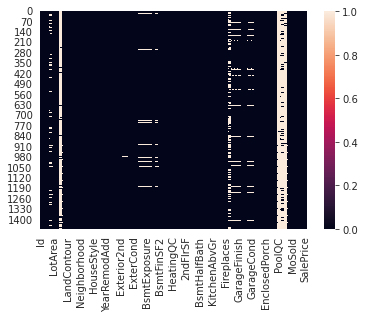

In [61]:
sns.heatmap(hp_train.isnull())

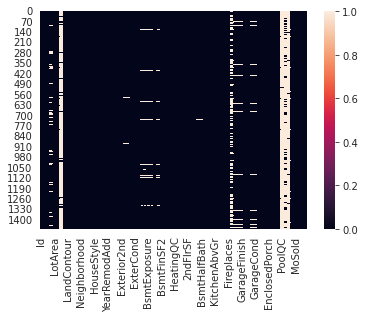

In [62]:
sns.heatmap(hp_test.isnull())

Now we find out the Target variable's distribution. Looking at the below graph, we can see that SalePrice is right skewed making our interpretation a little difficult, this is why we will use log transformation to reduce the skewness. 

Skew is the degree of distortion from a normal distribution of a graph.

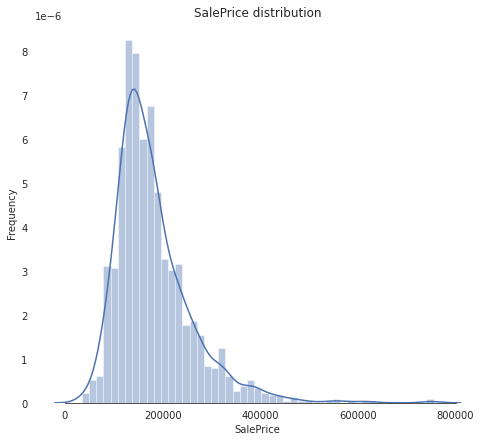

In [63]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))

# Check the distribution 
sns.distplot(hp_train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

In [64]:
# Skew
print("Skewness: %f" % hp_train['SalePrice'].skew())

Skewness: 1.882876


FEATURE SELECTION

Now we will use the correlation heatmap to find out what independant variables are important in predicting our target variable. Using the below map, and sorting the values, we can see OverallQual and GrLivArea are highly correlated with the SalePrice. 

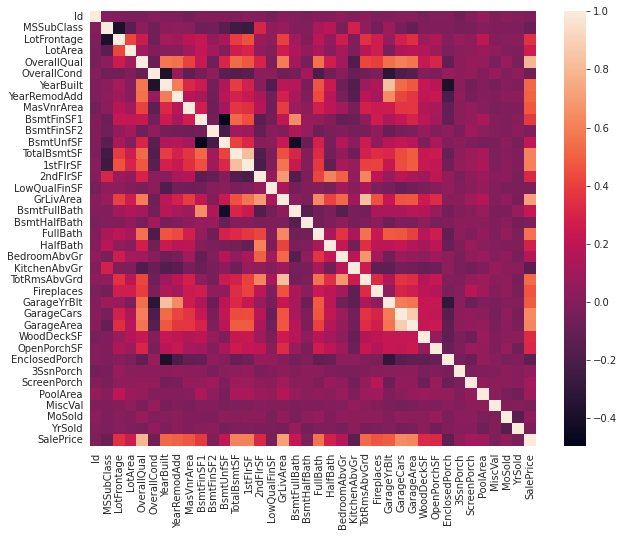

In [65]:
f, ax = plt.subplots(figsize=(10, 8))
corr = hp_train.corr()
sns.heatmap(corr)
plt.show()

In [66]:
hp_train.corr()['SalePrice'].sort_values()

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
Id              -0.021917
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
3SsnPorch        0.044584
MoSold           0.046432
PoolArea         0.092404
ScreenPorch      0.111447
BedroomAbvGr     0.168213
BsmtUnfSF        0.214479
BsmtFullBath     0.227122
LotArea          0.263843
HalfBath         0.284108
OpenPorchSF      0.315856
2ndFlrSF         0.319334
WoodDeckSF       0.324413
LotFrontage      0.351799
BsmtFinSF1       0.386420
Fireplaces       0.466929
MasVnrArea       0.477493
GarageYrBlt      0.486362
YearRemodAdd     0.507101
YearBuilt        0.522897
TotRmsAbvGrd     0.533723
FullBath         0.560664
1stFlrSF         0.605852
TotalBsmtSF      0.613581
GarageArea       0.623431
GarageCars       0.640409
GrLivArea        0.708624
OverallQual      0.790982
SalePrice        1.000000
Name: SalePr

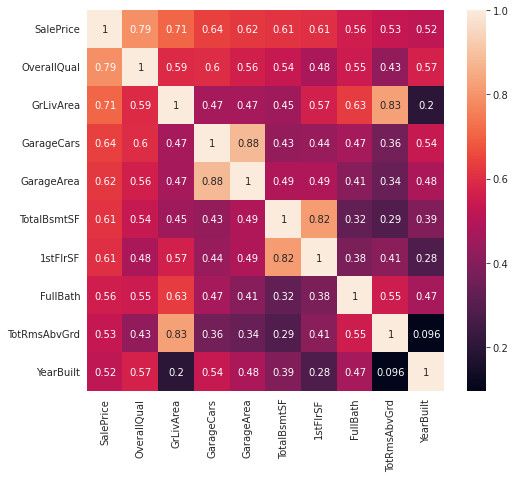

In [67]:
f, ax = plt.subplots(figsize=(8, 7))
top_corr = hp_train[corr.SalePrice.sort_values(ascending=False)[:10].index].corr()
sns.heatmap(top_corr, annot=True)
plt.show()

Now we willindividually chacke if either of these independent variables have any outliers and remove the same. Outliers are values that differ in great amounts from other values with it. These anomalies can cause issues with the predictions of target variable values.

Scatterplot of target value against these dependant variables can help identify the outliers, in the below graph 1, we can see 2 anomalies and these can be found out by checking these values within the ranges of the graph as seen later.

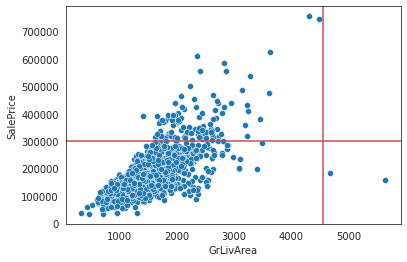

In [68]:
sns.scatterplot(data=hp_train,x='GrLivArea', y='SalePrice')
plt.axhline(y=300000, color='r')
plt.axvline(x=4550, color='r')

In [69]:
hp_train[(hp_train['GrLivArea']>4500) & (hp_train['SalePrice']<300000)][['SalePrice', 'GrLivArea']]

,SalePrice,GrLivArea
523,184750,4676
1298,160000,5642


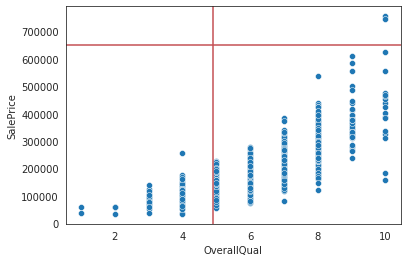

In [70]:
sns.scatterplot(data=hp_train,x='OverallQual', y='SalePrice')
plt.axvline(x=4.9,color='r')
plt.axhline(y=650000,color='r')

In [71]:
hp_train[(hp_train['OverallQual']<5) & (hp_train['SalePrice']<200000)][['SalePrice', 'OverallQual']]

,SalePrice,OverallQual
17,90000,4
29,68500,4
30,40000,4
39,82000,4
48,113000,4
...,...,...
1412,90000,4
1416,122500,4
1432,64500,4
1436,120500,4


FEATURE ENGINEERING

Now, we will check for any missing valuesin our dataset. This is found with the help of missing_percent. We check for the values and return the nan percent if any.

In [72]:
# Define function to get the percentage of missing values in attributes
def missing_percent(hp_train):
    nan_percent= 100*(hp_train.isnull().sum()/len(hp_train))
    nan_percent= nan_percent[nan_percent>0].sort_values()
    return nan_percent

In [73]:
# Missing values in attrbiutes comparison in %
nan_percent= missing_percent(hp_train)
nan_percent

Electrical       0.068493
MasVnrType       0.547945
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
BsmtExposure     2.602740
BsmtFinType2     2.602740
GarageCond       5.547945
GarageQual       5.547945
GarageFinish     5.547945
GarageType       5.547945
GarageYrBlt      5.547945
LotFrontage     17.739726
FireplaceQu     47.260274
Fence           80.753425
Alley           93.767123
MiscFeature     96.301370
PoolQC          99.520548
dtype: float64

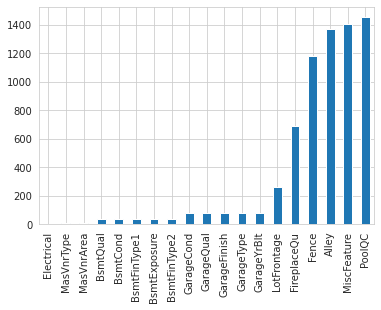

In [74]:
sns.set_style("whitegrid")
missing = hp_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [75]:
for name in hp_train.columns:
    x = hp_train[name].isna().sum()
    if x > 0:
        val_list = np.random.choice(hp_train.groupby(name).count().index, x, p=hp_train.groupby(name).count()['Id'].values /sum(hp_train.groupby(name).count()['Id'].values))
        hp_train.loc[hp_train[name].isna(), name] = val_list

In [76]:
sum(hp_train.isna().sum())

0

In [77]:
for name in hp_test.columns:
    x = hp_test[name].isna().sum()
    if x > 0:
        val_list = np.random.choice(hp_test.groupby(name).count().index, x, p=hp_test.groupby(name).count()['Id'].values /sum(hp_test.groupby(name).count()['Id'].values))
        hp_test.loc[hp_test[name].isna(), name] = val_list

In [78]:
sum(hp_test.isna().sum())

0

Below, we are converting allthe column values to string for a cleaner and better data.

In [79]:
# Some of the non-numeric predictors are stored as numbers; convert them into strings 
hp_train['MSSubClass'] = hp_train['MSSubClass'].apply(str)
hp_train['YrSold'] = hp_train['YrSold'].astype(str)
hp_train['MoSold'] = hp_train['MoSold'].astype(str)

In [80]:
hp_test['MSSubClass'] = hp_test['MSSubClass'].apply(str)
hp_test['YrSold'] = hp_test['YrSold'].astype(str)
hp_test['MoSold'] = hp_test['MoSold'].astype(str)

Below, we will try to normalise the skewed feature for our interpretation. We will use log transformation in order to fix the issue. we can use log transformation to this data to make it as normal as possible so that the statistical analysis results from this data become more valid.

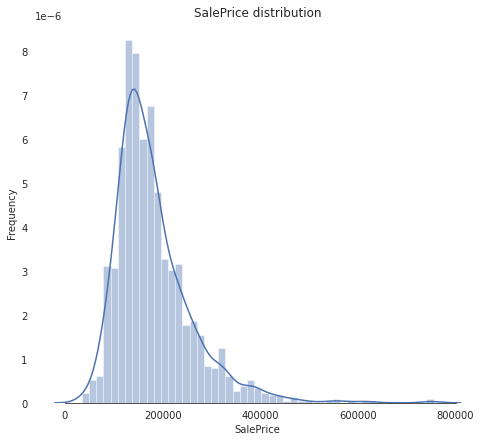

In [81]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))

# Check the distribution 
sns.distplot(hp_train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

In [82]:
# Apply log-transfomation (log(1+x))
hp_train["SalePrice"] = np.log1p(hp_train["SalePrice"])


 mu = 12.02 and sigma = 0.40



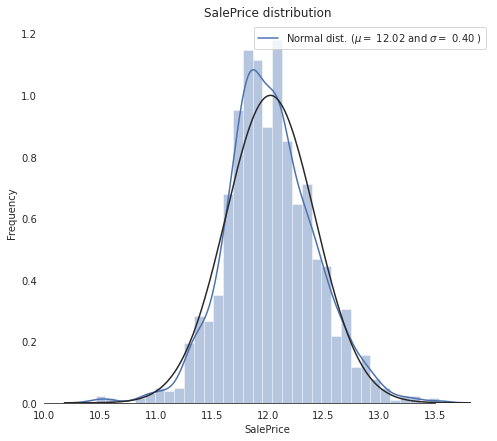

In [83]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(hp_train['SalePrice'] , fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(hp_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

The graph now looks much more normalised after log transformation. We will now remove the outliers that we found in the dependant variables earlier.

In [84]:
# Remove outliers
hp_train.drop(hp_train[(hp_train['OverallQual'] < 5) & (hp_train['SalePrice'] > 200000)].index, inplace=True)
hp_train.drop(hp_train[(hp_train['GrLivArea'] > 4500) & (hp_train['SalePrice'] < 300000)].index, inplace=True)
hp_train.reset_index(drop=True, inplace=True)

Below, we are splitting the train dataset into individual variables and target dataset for model building.

In [85]:
X = hp_train.drop(columns=['SalePrice'])
y = hp_train['SalePrice']

Now, we will set pipelines for transformations. Doing it effectively for each category as mentioned below.

In [86]:
#  integer category
int_cat_features = list(X.select_dtypes(include='int64').columns)
int_cat_transformers = Pipeline(steps=[('imputer', SimpleImputer()),
                                      ('scale', StandardScaler())])

# string category
str_cat_features = list(X.select_dtypes(include='object').columns)
str_cat_transformers = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                       ('one-hot', OneHotEncoder(handle_unknown='ignore'))])

# continues neumerical - floats
float_cat_features = list(X.select_dtypes(include='float64').columns)
float_cat_transformers = Pipeline(steps=[('imputer', SimpleImputer()),
                                         ('scale', StandardScaler())])

We will now split and use the K foldvalidation.
K-Fold CV is where a given data set is split into a K number of sections/folds where each fold is used as a testing set at some point. Lets take the scenario of 5-Fold cross validation(K=5). Here, the data set is split into 5 folds. In the first iteration, the first fold is used to test the model and the rest are used to train the model. In the second iteration, 2nd fold is used as the testing set while the rest serve as the training set. This process is repeated until each fold of the 5 folds have been used as the testing set.

In [87]:
# Setup cross validation folds
kf = KFold(n_splits=5, random_state=42, shuffle=True)

I am now going to use 3 models for my dataset. First is the Forest Regression model, the Support Vector Regressor and Gradient Booster Model.



In [88]:
# Model building

def model_building(model):
    #applying transformations
    preprocess = ColumnTransformer(transformers=[('int_cat', int_cat_transformers, int_cat_features),
                                                 ('str_cat', str_cat_transformers, str_cat_features),
                                                 ('float_cat', float_cat_transformers, float_cat_features)
                                                ])
    # preprocessing and modeling pipeline
    pipe = Pipeline(steps=[('preprocessing', preprocess),
                           ('modeling', model)])
    
    return pipe
    
# Cross validating
def cross_validate_pipeline(pipeline, X, y):
    cv_scores = -cross_val_score(pipeline, X, y, scoring="neg_root_mean_squared_error", cv=kf)
    return cv_scores

In [89]:
models = [('SVR', SVR()),
          ('XGBRegressor',XGBRegressor()),
         ]


for name,model in models:
    model_pipeline = model_building(model)
    cv_scores = cross_validate_pipeline(model_pipeline, X, y)
    print(f'{name :20} {cv_scores.mean()}')

SVR                  0.14240500237626677
[21:17:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:17:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:17:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:17:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:17:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor         0.12575159666588132


To improve results is to do hyper-parameters tuning of each model using GridSearchCV or RandomSearchCV and also applying stacking. From there it can improve the model in terms of accuracy to predict.

In [90]:
models = [('SVR',
           SVR(),
           {'modeling__C':[20,30,40],
            'modeling__epsilon':[0.007,0.008,0.009],
            'modeling__gamma':[0.0002,0.0003,0.0004],}),
          
          
          ('XGBRegressor',
           XGBRegressor(),
           {'modeling__learning_rate':[0.01],
            'modeling__max_depth':[4],
            'modeling__n_estimators':[3000],
            'modeling__subsample':[0.6,0.5,0.7,]})
         ]

#[2000,3000]

for name, model, param_grid in models:
    pipe = model_building(model)
    rs = RandomizedSearchCV(estimator = pipe, 
                            param_distributions = param_grid,
                            scoring="neg_mean_squared_error", 
                            cv = 5,
                            n_iter = 5,
                            random_state = 34)
    rs.fit(X,y)
    print(f'{name :20} {np.sqrt(np.negative(rs.best_score_))}')
    print(f'{name :20} {rs.best_params_}')

SVR                  0.11237323316776973
SVR                  {'modeling__gamma': 0.0003, 'modeling__epsilon': 0.009, 'modeling__C': 20}
[21:18:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:18:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:18:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:18:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:19:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:19:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:19:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in f

In [91]:
svr_model= SVR(gamma= 0.0003,
               epsilon= 0.009,
               C= 30)

xgb_model= XGBRegressor(subsample=0.5,
                        n_estimators=3000,
                        max_depth=4,
                        learning_rate=0.01)

# Stack up all the models above, optimized using xgboost
stack_reg = StackingCVRegressor(regressors=(svr_model, xgb_model),
                                meta_regressor=svr_model,
                                use_features_in_secondary=True)

In [92]:
stack_model = [('StackingCVRegressor', stack_reg)]


for name,model in stack_model:
    model_pipeline = model_building(model)
    cv_scores = cross_validate_pipeline(model_pipeline, X, y)
    print(f'{name :20} {cv_scores.mean()}')

StackingCVRegressor  nan


In [93]:
# modeling
model = model_building(stack_reg)
# training
model.fit(X,y)
# making predictions
preds = model.predict(hp_test)

[21:22:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:22:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:22:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:22:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:22:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:23:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [94]:
output = pd.DataFrame(data={'Id':hp_test['Id'],'SalePrice':np.expm1(preds)})
output.to_csv('submission.csv', index=False)
print('Your submission was successfully saved!')

Your submission was successfully saved!


SHAP

We will begin by installing SHAP using the below steps.

In [95]:
!pip install shap

In [143]:
import shap

In [144]:
url = 'https://raw.githubusercontent.com/akshatananjappa/DataScience_Assignment/master/Dataset/house-prices-advanced-regression-techniques/train.csv'
hp_train1 = pd.read_csv(url)
url = 'https://raw.githubusercontent.com/akshatananjappa/DataScience_Assignment/master/Dataset/house-prices-advanced-regression-techniques/test.csv'
hp_test1 = pd.read_csv(url)
#hp_dataframe.drop('Id',inplace=True,axis=1)

In [145]:
train_missing = hp_train1.isna().sum() / hp_train1.shape[0]
train_missing[train_missing > 0.7]

Alley          0.937671
PoolQC         0.995205
Fence          0.807534
MiscFeature    0.963014
dtype: float64

In [146]:
test_missing = hp_test1.isna().sum() / hp_test1.shape[0]
test_missing[test_missing > 0.7]

Alley          0.926662
PoolQC         0.997944
Fence          0.801234
MiscFeature    0.965045
dtype: float64

In [147]:
hp_train1.drop(train_missing[train_missing > 0.7].index, axis = 1, inplace = True)
hp_test1.drop(test_missing[test_missing > 0.7].index, axis = 1, inplace = True)

In [148]:
hp_train1['LotFrontage'].interpolate(axis=0, inplace=True)
hp_train1[['MasVnrType']].fillna('None', inplace=True)
hp_train1.dropna(subset=['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond'], inplace=True)
hp_train1.dropna(subset=['BsmtQual', 'BsmtCond', 'BsmtFinType1'], inplace=True)
hp_train1.dropna(subset=['MasVnrType', 'MasVnrArea'], inplace=True)
hp_train1.drop('FireplaceQu', axis=1, inplace=True)
hp_train1['BsmtExposure'].fillna('No', inplace=True)
hp_train1['BsmtFinType2'].fillna('Unf', inplace=True)
hp_train1['Electrical'].fillna('SBrkr', inplace=True)

In [149]:
hp_test1.fillna(method='ffill', inplace=True)
hp_test1.fillna(method='bfill', inplace=True)

In [150]:
# Copy Train data excluding target
trainData_Copy = hp_train1.drop(['SalePrice', 'Id'], axis=1).copy()
testData_Copy = hp_test1.drop('Id', axis=1).copy()
# Combine Train and test for One Hot Encoding
combined_Data = pd.concat([trainData_Copy,testData_Copy], keys = [0,1])
# Do One Hot Encoding for categorical features
combined_Data = pd.get_dummies(combined_Data)
# Separate Train data and test data
X_train = combined_Data.xs(0)
X_test = combined_Data.xs(1)
y_train = hp_train1["SalePrice"]



In [151]:
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor()
rfc.fit(X_train, y_train)
rfc_predict = rfc.predict(X_test)


Error(RMSE) of Random Forest Regressor: 0.17001

In [152]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor()
mlp.fit(X_train, y_train)
mlp_predict = mlp.predict(X_test)

Error(RMSE) of MLP Regressor: 0.42138

In [153]:
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor()
clf.fit(X_train, y_train)
clf_predict = clf.predict(X_test)

Error(RMSE) of Decision Tree Regressor: 0.20875

In [154]:
from sklearn.ensemble import GradientBoostingRegressor
search_random = {'n_estimators': range(1000, 5000, 100), 'learning_rate':[0.01, 0.1, 0.05]}
abc = GradientBoostingRegressor()
abc.fit(X_train, y_train)
abc_predict = abc.predict(X_test)

Error(RMSE) of Gradient Boosting Regressor: 0.13910

In [106]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_test)

SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples

We can see OverallQual be the most impacting feature which has a highest  effect of the SalePrice of a particular house.

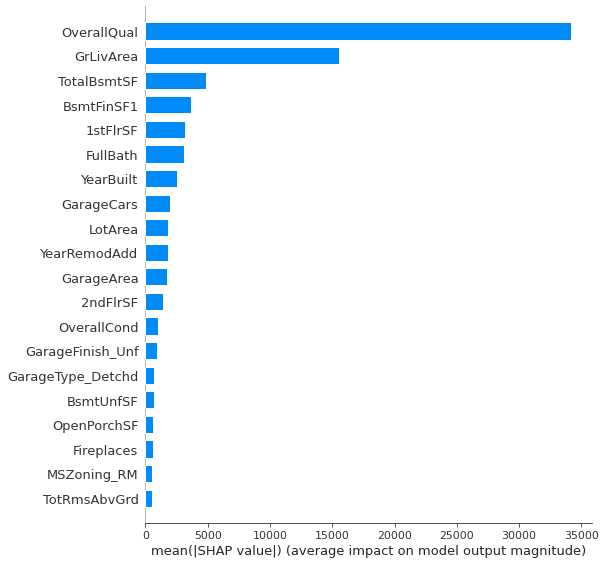

In [107]:
shap_values = shap.TreeExplainer(rfc).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

SHAP decision plots show how complex models arrive at their predictions (i.e., how models make decisions)

The output of the model is represented by the x-axis. The units are log odds in this situation. At explainer.expected value, the plot is centered on the x-axis. All SHAP values are proportional to the model's predicted value, just as the effects of a linear model are proportional to the intercept. The model's features are listed on the y-axis. By default, the features are sorted by relevance in ascending order. The significance is estimated based on the number of observations shown. This is usually not the same as the overall relevance ranking of the dataset. The decision plot additionally enables hierarchical cluster feature ordering and user-defined feature ordering in addition to feature importance ranking. The prediction for each observation is represented.

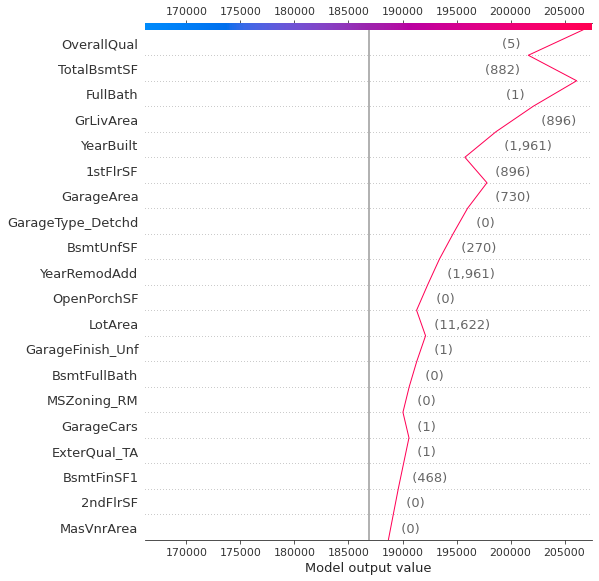

In [108]:
#SHAP2

expected_value = explainer.expected_value[0]
r = shap.decision_plot(expected_value, shap_values[0], X_test, return_objects=True)

Conclusion

I have first determined which algorithm has the lowest RMSE using the Stacking CV model, after individually finding the values. Also, after SHAPI have again modled the train and test without string conversion and comapred about 3 models with each other to find the most accurate. Accprding to my findings, I have seen Gradient booster to be most accurate as we can see that the gradient boosting regressor has the lowest error rate (RMSE).

Gradient boosting models are also becoming more popular as a result of their ability to categorize complex datasets, and have recently been utilized to win a number of Kaggle data science challenges. 

In order to improve results, we can also use stacking, where I have combined models. The stacked model also has a smaller root mean square error (RMSE) than the others because it optimally integrates model predictions to generate a new set of predictions, and the stacked model's overall predictive accuracy is higheras seen from my Kaggle score.

My Contributions

In most of the public kernels that I referred to, they have either used just model stacking or compared RMSE with individual models. I have done both in my notebook. I have also checked for RMSE by converting all columns to stringand without the same.

Another thing different in my approach is the hyper parameter tuning, I have used a variable while stacking to hypertune in the same block instead of doing it separately. 

My SHAP output is based on the output from models without string conversion. I have taken refrence of several kernels and combined the best techniques toget a Kaggle score of 

In my K-fold validation technique, Ihave split it to 5 folds whereas in public kernels they all took it only by a min value.I could see a better accuracy in mine.


REFERENCES:

https://medium.datadriveninvestor.com/a-regression-problem-with-python-house-prices-advanced-regression-techniques-98616d31f0ab

https://becominghuman.ai/house-prices-advanced-regression-techniques-ad9341385712

https://colab.research.google.com/drive/1p9yZEEDbWGmWZP6yNKupmLzxTaiz0R39#scrollTo=1ZGfJPHTkQVV

Licencing

Copyright [2021] [Akshata Nanjappa]

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

 http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.